In [1]:
import pandas as pd
import numpy as np
import re
import string
import joblib 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_excel("/content/Data_train_v2.xlsx")
data_dev = pd.read_excel("/content/Data_dev_v2.xlsx")
data_test = pd.read_excel("/content/Data_test_v2.xlsx")

In [3]:
data_train.rename(columns = {'Tag':'Tag_raw'}, inplace = True)
data_train.rename(columns = {'Tag_IOB': 'Tag'}, inplace = True)
data_dev.rename(columns = {'Tag':'Tag_raw'}, inplace = True)
data_dev.rename(columns = {'Tag_IOB': 'Tag'}, inplace = True)
data_test.rename(columns = {'Tag':'Tag_raw'}, inplace = True)
data_test.rename(columns = {'Tag_IOB': 'Tag'}, inplace = True)
data_train['Tag'] = data_train['Tag'].fillna('O')
data_dev['Tag'] = data_dev['Tag'].fillna('O')
data_test['Tag'] = data_test['Tag'].fillna('O')

In [4]:
data_train['Word'] = data_train['Word'].astype(str)
data_dev['Word'] = data_dev['Word'].astype(str)
data_test['Word'] = data_test['Word'].astype(str)

In [5]:
data_full = pd.concat([data_train, data_dev, data_test])

In [6]:
data_dev.head()

,Unnamed: 0,Word,Tag_raw,Sentence #,Tag
0,0,Miều,ORGANIZATION,0,B-ORGANIZATION
1,1,Fashionista,ORGANIZATION,0,I-ORGANIZATION
2,2,hiện,O,0,O
3,3,có,O,0,O
4,4,5,O,0,O


In [7]:
words = list(set(data_full["Word"].values))
# words.append("ENDPAD")
n_words = len(words); n_words

22267

In [8]:
## Tạo bộ tag
tags = list(set(data_full["Tag"].values))
n_tags = len(tags); n_tags

11

In [9]:
col_1 = data_full["Tag"]

# Đếm số lần xuất hiện của 'A'
count_a = col_1.value_counts()['O']

# Tính phần trăm
(count_a / len(col_1)) * 100

87.99276497472586

<Axes: >

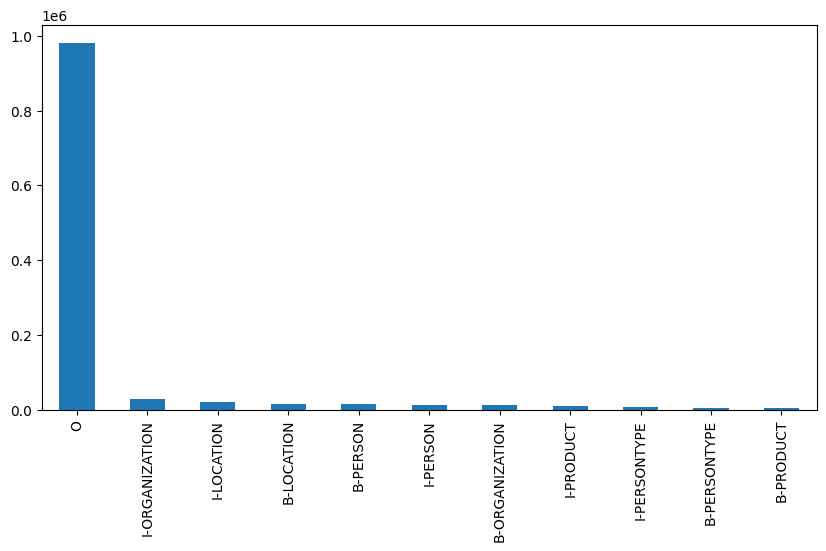

In [10]:
data_full["Tag"].value_counts().plot(kind="bar", figsize=(10,5))

In [11]:
tags

['I-PERSONTYPE',
 'B-PRODUCT',
 'B-PERSON',
 'B-PERSONTYPE',
 'I-PRODUCT',
 'B-ORGANIZATION',
 'I-PERSON',
 'O',
 'I-LOCATION',
 'B-LOCATION',
 'I-ORGANIZATION']

In [12]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter_train = SentenceGetter(data_train)
getter_dev = SentenceGetter(data_dev)

In [14]:
sent_train = getter_train.get_next()
sent_dev = getter_dev.get_next()

In [15]:
sentences_train = getter_train.sentences
sentences_dev = getter_dev.sentences

In [16]:
sentences_train[1]

[('Sáng', 'O'),
 ('30-6', 'O'),
 (',', 'O'),
 ('văn', 'O'),
 ('phòng', 'O'),
 ('đại', 'O'),
 ('diện', 'O'),
 ('báo', 'B-ORGANIZATION'),
 ('Tuổi', 'I-ORGANIZATION'),
 ('Trẻ', 'I-ORGANIZATION'),
 ('tại', 'O'),
 ('Huế', 'B-LOCATION'),
 ('(', 'O'),
 ('380', 'B-LOCATION'),
 ('Nguyễn', 'I-LOCATION'),
 ('Trung', 'I-LOCATION'),
 ('Trực', 'I-LOCATION'),
 (',', 'O'),
 ('P', 'B-LOCATION'),
 ('.', 'I-LOCATION'),
 ('Vĩnh', 'I-LOCATION'),
 ('Lạc', 'I-LOCATION'),
 (',', 'O'),
 ('Rạch', 'B-LOCATION'),
 ('Giá', 'I-LOCATION'),
 (',', 'O'),
 ('Kiên', 'B-LOCATION'),
 ('Giang', 'I-LOCATION'),
 (')', 'O'),
 ('đã', 'O'),
 ('làm', 'O'),
 ('lễ', 'O'),
 ('khánh', 'O'),
 ('thành', 'O'),
 ('và', 'O'),
 ('chính', 'O'),
 ('thức', 'O'),
 ('đưa', 'O'),
 ('vào', 'O'),
 ('sử', 'O'),
 ('dụng', 'O'),
 ('.', 'O'),
 ('Đây', 'O'),
 ('là', 'O'),
 ('văn', 'O'),
 ('phòng', 'O'),
 ('thứ', 'O'),
 ('8', 'O'),
 ('của', 'O'),
 ('báo', 'B-ORGANIZATION'),
 ('Tuổi', 'I-ORGANIZATION'),
 ('Trẻ', 'I-ORGANIZATION'),
 ('được', 'O'),
 ('xây

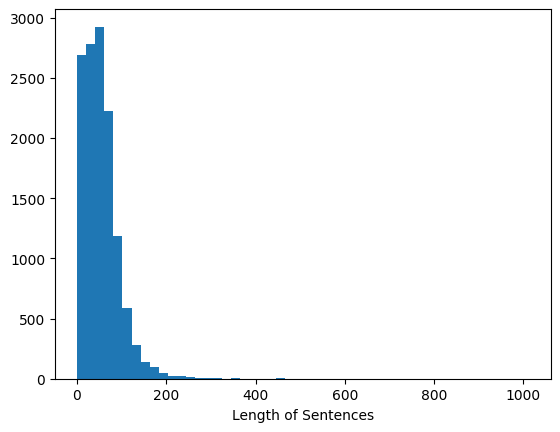

In [17]:
plt.hist([len(s) for s in sentences_train],bins= 50)
plt.xlabel("Length of Sentences")
plt.show()

In [18]:
data_full.groupby(['Sentence #']).count().max()

Unnamed: 0    1011
Word          1011
Tag_raw       1011
Tag           1011
dtype: int64

In [19]:
x = data_train.groupby('Sentence #').count()

#Mức phân vị thứ 75, 80, 95 
print(x['Word'].quantile(q = 0.75))
print(x['Word'].quantile(q = 0.80))
print(x['Word'].quantile(q = 0.95))

73.0
80.0
123.0


In [20]:

# word2idx = {w: i + 1 for i, w in enumerate(words)}
# tag2idx = {t: i for i, t in enumerate(tags)}
# idx2tag = {i: w for w, i in tag2idx.items()}

# idx2tag

In [21]:
max_len = 100
word2idx = {word: idx + 2 for idx, word in enumerate(words)}
word2idx["--UNKNOWN_WORD--"]=0
word2idx["--PADDING--"]=1
index2word = {idx: word for word, idx in word2idx.items()}

In [22]:
tag2idx = {tag: idx + 1 for idx, tag in enumerate(tags)}
tag2idx["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2idx.items()}

In [23]:
tag2idx

{'I-PERSONTYPE': 1,
 'B-PRODUCT': 2,
 'B-PERSON': 3,
 'B-PERSONTYPE': 4,
 'I-PRODUCT': 5,
 'B-ORGANIZATION': 6,
 'I-PERSON': 7,
 'O': 8,
 'I-LOCATION': 9,
 'B-LOCATION': 10,
 'I-ORGANIZATION': 11,
 '--PADDING--': 0}

In [24]:
import operator
for k,v in sorted(word2idx.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
GHz 2
29/1 3
Phuket 4
"Trong 5
HSMT 6
Catalan 7
Nuôi 8
loang 9


In [25]:
import pickle
with open('tag2idx.pkl', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('word2idx', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
from keras.utils import pad_sequences

X_train = [[word2idx[w[0]] for w in s] for s in sentences_train]
X_train = pad_sequences(maxlen=max_len, sequences=X_train, padding="post", value=n_words-1)

X_dev = [[word2idx[w[0]] for w in s] for s in sentences_dev]
X_dev = pad_sequences(maxlen=max_len, sequences=X_dev, padding="post", value=n_words-1)

In [27]:
y_train = [[tag2idx[w[1]] for w in s] for s in sentences_train]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])

y_dev = [[tag2idx[w[1]] for w in s] for s in sentences_dev]
y_dev = pad_sequences(maxlen=max_len, sequences=y_dev, padding="post", value=tag2idx["O"])

In [28]:
from keras.utils import to_categorical
y_train = [to_categorical(i, num_classes=n_tags+1) for i in y_train]
y_dev = [to_categorical(i, num_classes=n_tags+1) for i in y_dev]

In [29]:
import keras
from keras.models import Model,Sequential
from keras.layers import LSTM, Embedding, Dense, Input, TimeDistributed, Dropout, Bidirectional
import keras as k

In [30]:
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam

In [31]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model

In [32]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = n_words+2,output_dim = max_len,input_length = max_len)(input_word)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=128,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(n_tags+1,activation = 'softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2226900   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         234496    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 12)          3084      
 ibuted)                                                         
                                                                 
Total params: 2,464,480
Trainable params: 2,464,480
Non-train

In [33]:
from keras.utils import plot_model

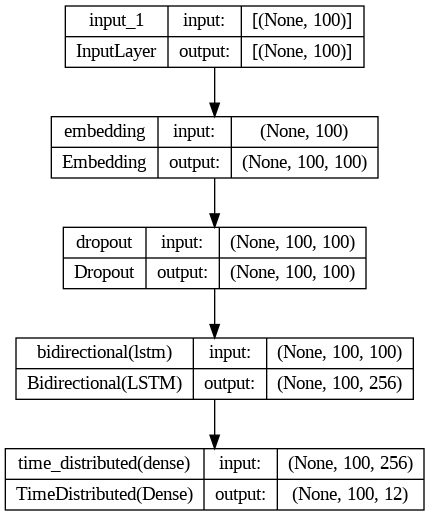

In [34]:
dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

In [35]:
adam = k.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)
model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [36]:
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=10,
                    validation_data=(X_dev, np.array(y_dev)), verbose=1)

Epoch 1/10
102/102 [==============================] - 185s 2s/step - loss: 0.5000 - accuracy: 0.9254 - val_loss: 0.2337 - val_accuracy: 0.9456
Epoch 2/10
102/102 [==============================] - 185s 2s/step - loss: 0.2096 - accuracy: 0.9410 - val_loss: 0.1788 - val_accuracy: 0.9512
Epoch 3/10
102/102 [==============================] - 182s 2s/step - loss: 0.1629 - accuracy: 0.9512 - val_loss: 0.1599 - val_accuracy: 0.9560
Epoch 4/10
102/102 [==============================] - 180s 2s/step - loss: 0.1257 - accuracy: 0.9640 - val_loss: 0.1386 - val_accuracy: 0.9652
Epoch 5/10
102/102 [==============================] - 180s 2s/step - loss: 0.0915 - accuracy: 0.9747 - val_loss: 0.1311 - val_accuracy: 0.9693
Epoch 6/10
102/102 [==============================] - 182s 2s/step - loss: 0.0726 - accuracy: 0.9798 - val_loss: 0.1208 - val_accuracy: 0.9718
Epoch 7/10
102/102 [==============================] - 177s 2s/step - loss: 0.0607 - accuracy: 0.9827 - val_loss: 0.1170 - val_accuracy: 0.9733

In [37]:
pip install plot_keras_history

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9457 sha256=fc0c9347f37acbeceab6ee417ef2d71dc1b8f495f9cb2a016fccdfe0ea91c836
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320501 sha256=515ca2d8324781e1f130f52b21747fd16e9ad5c7e6963d8e1d962f044d61f748
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

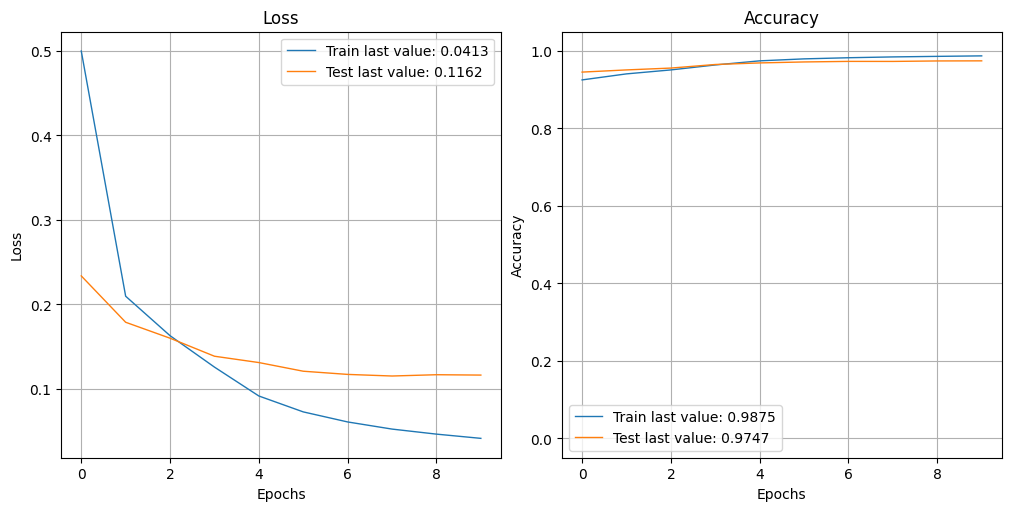

In [38]:
from plot_keras_history import plot_history
plot_history(history.history)

In [39]:
y_pred = model.predict(X_dev)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_dev, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

79/79 [==============================] - 17s 212ms/step
Accuracy: 0.9747/


In [40]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=7ce957105e1e2b352a09311d3e44ecde2613f068a08f2c401aca6cc2b9e39c8b
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [41]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report,accuracy_score

In [42]:
dev_pred = model.predict(X_dev, verbose=1)
train_pred = model.predict(X_train, verbose=1)

408/408 [==============================] - 53s 126ms/step


In [43]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(index2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
dev_pred_labels = pred2label(dev_pred)
dev_actual_labels = pred2label(y_dev)

train_pred_labels = pred2label(train_pred)
train_actual_labels = pred2label(y_train)

In [66]:
print("accuracy: {:.1%}".format(accuracy_score(train_actual_labels, train_pred_labels)))
print("F1-score: {:.1%}".format(f1_score(train_actual_labels, train_pred_labels)))
print("precision: {:.1%}".format(precision_score(train_actual_labels, train_pred_labels)))
print("recall_score: {:.1%}".format(recall_score(train_actual_labels, train_pred_labels)))

accuracy: 89.0%
F1-score: 80.0%
precision: 77.3%
recall_score: 82.9%


In [45]:
print("F1-score: {:.1%}".format(f1_score(dev_actual_labels, dev_pred_labels)))
print("F1-score: {:.1%}".format(f1_score(train_actual_labels, train_pred_labels)))

F1-score: 51.9%
F1-score: 80.0%


In [46]:
model.save("model_ner.h5")

In [47]:
print(classification_report(train_actual_labels, train_pred_labels))

              precision    recall  f1-score   support

    LOCATION       0.81      0.89      0.85     11173
ORGANIZATION       0.73      0.82      0.77      8089
      PERSON       0.89      0.91      0.90      8237
  PERSONTYPE       0.63      0.62      0.63      3625
     PRODUCT       0.59      0.64      0.61      2862

   micro avg       0.77      0.83      0.80     33986
   macro avg       0.73      0.78      0.75     33986
weighted avg       0.77      0.83      0.80     33986



In [48]:
model.evaluate(X_dev, np.array(y_dev))

79/79 [==============================] - 9s 110ms/step - loss: 0.1162 - accuracy: 0.9747


[0.11623629182577133, 0.9746677279472351]

In [49]:
i = 1
p = model.predict(np.array([X_dev[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_dev[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_dev[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

1/1 [==============================] - 0s 68ms/step
Word           ||True ||Pred
1.6.1931       : I-LOCATION I-LOCATION
.com           : I-LOCATION I-LOCATION
lýsau          : I-LOCATION I-LOCATION
Ngữ            : I-LOCATION I-LOCATION
3-6-2017       : I-LOCATION I-LOCATION
QS             : I-LOCATION I-LOCATION
lỳ             : I-LOCATION I-LOCATION
Hạt            : I-ORGANIZATION B-PERSONTYPE
H.T.P.         : B-LOCATION B-LOCATION
văn            : I-LOCATION I-LOCATION
soi            : I-ORGANIZATION I-ORGANIZATION
129/46         : B-LOCATION B-PERSONTYPE
lưu            : B-LOCATION B-LOCATION
lẽ             : B-LOCATION B-LOCATION
lỳ             : I-LOCATION I-LOCATION
SĐT:           : I-ORGANIZATION I-ORGANIZATION
Third          : B-LOCATION B-LOCATION
1.500.000.000  : B-LOCATION B-LOCATION
Mầm            : B-LOCATION B-LOCATION
lỳ             : I-LOCATION I-LOCATION
miết           : I-ORGANIZATION I-ORGANIZATION
308.172        : B-LOCATION B-LOCATION
lỳ             : I-LOCATION I

In [50]:
sentence = "Gần một tuần trước, TP Hà Nội bắt đầu tổng kiểm tra, xử lý vi phạm về trật tự an toàn giao thông, trật tự đô thị, trật tự công cộng trên địa bàn."
re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"  ", sentence).split()

padded_sentence = sentence + [word2idx["--PADDING--"]] * (100 - len(sentence))
padded_sentence = [word2idx.get(w, 0) for w in padded_sentence]

pred = model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

1/1 [==============================] - 1s 643ms/step
Gần            : O    
một            : O    
tuần           : O    
trước          : O    
TP             : B-LOCATION
Hà             : I-LOCATION
Nội            : I-LOCATION
bắt            : O    
đầu            : O    
tổng           : O    
kiểm           : O    
tra            : O    
xử             : O    
lý             : O    
vi             : O    
phạm           : O    
về             : O    
trật           : O    
tự             : O    
an             : O    
toàn           : O    
giao           : O    
thông          : O    
trật           : O    
tự             : O    
đô             : O    
thị            : O    
trật           : O    
tự             : O    
công           : O    
cộng           : O    
trên           : O    
địa            : O    
bàn            : O    



In [51]:
data_test
getter_test = SentenceGetter(data_test)
sent_test = getter_test.get_next()
sentences_test = getter_test.sentences

In [52]:
def senten(i):
  k = []
  for t in sentences_test[i]:
    k.append(t[0])
    m = " ".join(k)
  return m

In [53]:
len(sentences_test)

4309

In [54]:
import random 

In [55]:
i = random.randint(1, 4308)
sentence = str(senten(i))
re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"  ", sentence).split()

padded_sentence = sentence + [word2idx["--PADDING--"]] * (100 - len(sentence))
padded_sentence = [word2idx.get(w, 0) for w in padded_sentence]

pred = model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

1/1 [==============================] - 0s 72ms/step
Sau            : O    
khi            : O    
có             : O    
thông          : O    
tin            : O    
Ủy             : B-ORGANIZATION
ban            : I-ORGANIZATION
nhân           : I-ORGANIZATION
dân            : I-ORGANIZATION
huyện          : I-ORGANIZATION
An             : I-ORGANIZATION
Dương          : I-ORGANIZATION
đã             : O    
thành          : O    
lập            : O    
đoàn           : O    
kiểm           : O    
tra            : O    
công           : O    
tác            : O    
quản           : O    
lý             : O    
thu            : O    
chi            : O    
và             : O    
các            : O    
khoản          : O    
đóng           : O    
góp            : O    
của            : O    
cha            : O    
mẹ             : O    
học            : O    
sinh           : O    
đầu            : O    
năm            : O    
học            : O    
2017           : O    
2018       

In [56]:
X_test = [[word2idx[w[0]] for w in s] for s in sentences_test]
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words-1)

# pad the target - dev sample
y_test = [[tag2idx[w[1]] for w in s] for s in sentences_test]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

y_test = [to_categorical(i, num_classes=n_tags+1) for i in y_test]

In [57]:
test_pred = model.predict(X_test, verbose=1)

135/135 [==============================] - 14s 103ms/step


In [58]:
test_pred_labels = pred2label(test_pred)
test_actual_labels = pred2label(y_test)

In [59]:
print("F1-score: {:.1%}".format(f1_score(test_actual_labels, test_pred_labels)))

F1-score: 49.8%


In [60]:
print(classification_report(test_actual_labels, test_pred_labels))

              precision    recall  f1-score   support

    LOCATION       0.59      0.68      0.63      2268
ORGANIZATION       0.49      0.41      0.44      2400
      PERSON       0.67      0.46      0.55      2890
  PERSONTYPE       0.45      0.42      0.43       945
     PRODUCT       0.25      0.20      0.23      1071

   micro avg       0.53      0.47      0.50      9574
   macro avg       0.49      0.44      0.46      9574
weighted avg       0.53      0.47      0.49      9574

